# Business metrics
In this project we will be working on a database which carries data for a digital music marketplace company ("Chinook"). In this imagined scenario, we've been tasked by the company to investigate their data and optimise their business. Some of the question we'll answer include:
- Which new albums should be offered in the marketplace based on genre popularity?
- What does the total amount of sales per employee tell us about the employees' performance?
- The company wants to invest on advertising. Which countries are the most promising ones that could be targeted by an ad campaign?
- Buying full albums is costly in terms of copyright. What does the data tell us about the opportunity of switching to a single-track-based only marketplace?

In [1]:
# Import all necessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Open the connection object
conn = sqlite3.connect("chinook.db")

In [3]:
# Let's also define here a few functions that will let us streamline our work
def run_query(q):
    return pd.read_sql(q,conn)

def run_command(c):
    conn.isolation_level = None
    conn.execute(c)
    
def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view')"
    return run_query(q)

In [4]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


The schema provided for the database is shown below.

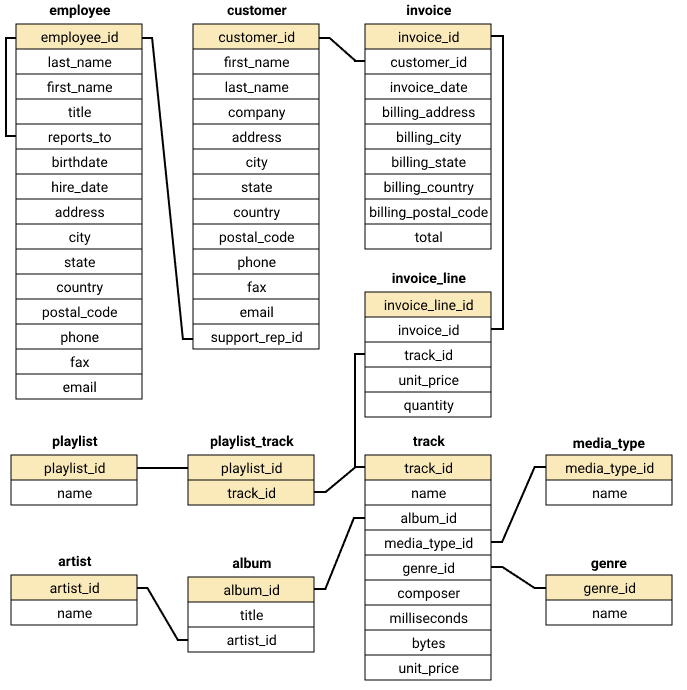

In [7]:
from IPython.display import Image
Image("schema.jpg")

## CHINOOK MARKET SEARCH: GENRES
As the first task of this scenario, the company has asked us to determine which new albums the marketplace should offer. The company has four new albums on hand:
- A Punk album by Red Tone
- A Hip-Hop album by Regal
- A Blues album by Slim Jim Bites
- A Pop album by Meteor and the Girl

However, the company wants to invest on the selling rights for only three of these albums. Which albums should be picked up by the company?

In [5]:
# First of all print out the genres represented in our database
q0 = '''
SELECT
    g.name Genre
FROM track t
LEFT JOIN media_type m ON m.media_type_id == t.media_type_id
LEFT JOIN genre g ON g.genre_id == t.genre_id
WHERE m.name LIKE '%audio%'
GROUP BY Genre
ORDER BY Genre
'''

run_query(q0)

,Genre
0,Alternative
1,Alternative & Punk
2,Blues
3,Bossa Nova
4,Classical
5,Easy Listening
6,Electronica/Dance
7,Heavy Metal
8,Hip Hop/Rap
9,Jazz


In [8]:
# Then determine the amount of units sold by genre
q1 = '''
SELECT
    g.name Genre,
    SUM(i.quantity) Units_sold
FROM invoice_line i
LEFT JOIN track t ON t.track_id == i.track_id
LEFT JOIN media_type m ON m.media_type_id == t.media_type_id
LEFT JOIN genre g ON g.genre_id == t.genre_id
WHERE m.name LIKE '%audio%'
GROUP BY Genre
ORDER BY Units_sold DESC;
'''

genre_sales = run_query(q1)

In [9]:
genre_sales["Units_sold_%"] = (genre_sales["Units_sold"]/genre_sales["Units_sold"].sum())*100
genre_sales

,Genre,Units_sold,Units_sold_%
0,Rock,2635,55.427009
1,Metal,619,13.020614
2,Alternative & Punk,492,10.349180
3,Latin,167,3.512831
4,R&B/Soul,159,3.344552
5,Blues,124,2.608330
6,Jazz,121,2.545225
7,Alternative,117,2.461085
8,Easy Listening,74,1.556584
9,Pop,63,1.325200


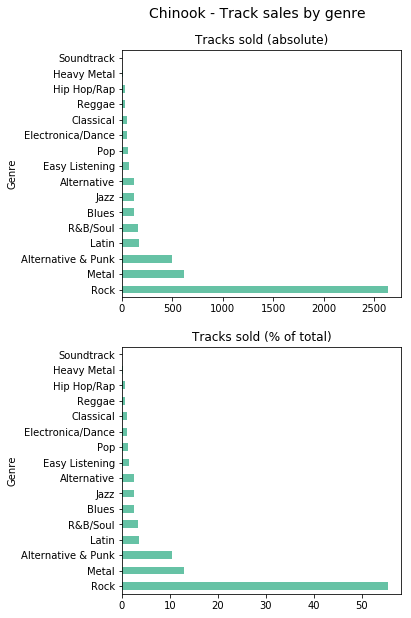

In [33]:
# Visualize our results
fig, axes = plt.subplots(2,1,figsize=(5,10))
fig.suptitle("Chinook - Track sales by genre",fontsize=14,y=.94)
fig.subplots_adjust(hspace=.2)
genre_sales.plot.barh(x="Genre",y="Units_sold",ax = axes[0],legend=False,
    title="Tracks sold (absolute)",
    colormap=plt.cm.Set2)
genre_sales.plot.barh(x="Genre",y="Units_sold_%",ax = axes[1],legend=False,
    title="Tracks sold (% of total)",
    colormap=plt.cm.Set2)

### RESULTS
- Of all the 20 audio genres represented in the Chinook database, only 15 have had any sales. 
- Pertaining to the record label request, all four genres were represented in sales.
- Among these, Punk had the most sales (492) followed by Blues (124), Pop (63) and Hip-Hop (33).

##### Data indicates that Chinook should add the albums by Red Tone, Slim Jim Bites and Meteor and the Girl, leaving out Regal.

## CHINOOK MARKET SEARCH: SALES AGENTS
For the second task of this scenario we have been asked to investigate the performance of the sales department of the company What can the data tell us about the Sales Agents?

In [22]:
# First of all print out all employee roles
q2 = '''
SELECT
    DISTINCT(title)
FROM employee
'''

run_query(q2)

,title
0,General Manager
1,Sales Manager
2,Sales Support Agent
3,IT Manager
4,IT Staff


In [23]:
# A quick look at the columns within the employee table...
q3 = "SELECT * FROM employee"
run_query(q3).dtypes

employee_id      int64
last_name       object
first_name      object
title           object
reports_to     float64
birthdate       object
hire_date       object
address         object
city            object
state           object
country         object
postal_code     object
phone           object
fax             object
email           object
dtype: object

In [24]:
# Ok, now select only the "Sales Support Agent" job title from among the employees, and order them by sales
q4 = '''
WITH sales_agents AS (
    SELECT *
    FROM employee
    WHERE title == 'Sales Support Agent'
)
    SELECT
        e.first_name || ' ' || e.last_name employee_name,
        e.birthdate,
        e.hire_date,
        e.country,
        SUM(i.total) total_sales
    FROM sales_agents e
    LEFT JOIN customer c ON c.support_rep_id == e.employee_id
    LEFT JOIN invoice i ON i.customer_id == c.customer_id
    GROUP BY employee_name
    ORDER BY total_sales DESC;
'''

agents_by_sales = run_query(q4)
agents_by_sales

,employee_name,birthdate,hire_date,country,total_sales
0,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,Canada,1731.51
1,Margaret Park,1947-09-19 00:00:00,2017-05-03 00:00:00,Canada,1584.00
2,Steve Johnson,1965-03-03 00:00:00,2017-10-17 00:00:00,Canada,1393.92


It seems that not all employees are performing equally, at least in terms of total sales. However, total sales as we've calculated them do not account for the number of days each of the employees has been working!

In [27]:
# Let's make a column where the total amount of days since hire is calculated for each sales agent
agents_by_sales["hire_date"] = pd.to_datetime(agents_by_sales["hire_date"])
import datetime as dt # The datetime library lets us operate on dates in a numeric fashion
now = dt.datetime.now()
agents_by_sales["days_since_hire"] = (now - agents_by_sales["hire_date"]).astype("timedelta64[D]")

Text(0.5,0,'Days since hire')

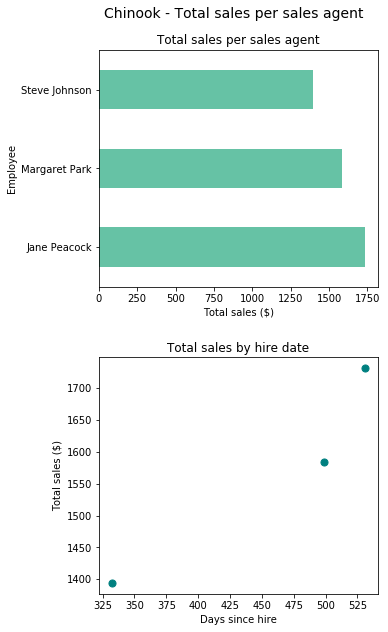

In [35]:
# Finally, visualize the results
fig, axes = plt.subplots(2,1,figsize=(5,10))
fig.suptitle("Chinook - Total sales per sales agent",fontsize=14,y=.94)
fig.subplots_adjust(hspace=.3)
agents_by_sales.plot.barh(x="employee_name",y="total_sales",ax = axes[0],legend=False,
    title="Total sales per sales agent",
    colormap=plt.cm.Set2)
axes[0].set_xlabel("Total sales ($)")
axes[0].set_ylabel("Employee")
agents_by_sales.plot.scatter(x="days_since_hire",y="total_sales",ax = axes[1],legend=False,
    title="Total sales by hire date",s=50,c='teal')
axes[1].set_ylabel("Total sales ($)")
axes[1].set_xlabel("Days since hire")

### RESULTS
- A superficial look at the amount of total sales seems to indicate that Jane Peacock is outperforming Margaret Park, which in turn outperforms Steve Johnson.
- However, the total amount of sales for each employee has a strong positive correlation with the amount of time they've been employed. This simply indicates that sales agents who have been employed longer have had a longer time to sell tracks, and is not a very useful result.

#### We need a better metric! 
An interesting one that comes to mind is the *average amount of sales per day*. We have all the data we need to calculate it!

In [34]:
agents_by_sales["avg_daily_sales"] = agents_by_sales["total_sales"]/agents_by_sales["days_since_hire"]

Text(0,0.5,'Employee')

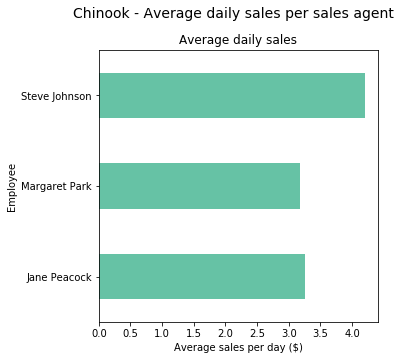

In [40]:
# Visualize the new results
fig, axes = plt.subplots(figsize=(5,5))
fig.suptitle("Chinook - Average daily sales per sales agent",fontsize=14,y=1)
agents_by_sales.plot.barh(x="employee_name",y="avg_daily_sales",ax = axes,legend=False,
    title="Average daily sales",
    colormap=plt.cm.Set2)
axes.set_xlabel("Average sales per day ($)")
axes.set_ylabel("Employee")

### FINAL RESULTS
As it turns out, *Steve Johnson is in fact the one outperforming the other employees!*

## CHINOOK MARKET SEARCH: ADVERTISEMENT CAMPAIGN
For the third task of our scenario we have been told that the company wants to invest in an advertisement campaign. Of course the company wants to invest its money as efficiently as possible, so we've been asked to identify 2-3 of the most promising markets for a targeted campaign.

In [41]:
# First of all let's write a query that'll let us build a DataFrame containing all useful sales data per each country.
# There are a lot of countries in our database, but many of them have just one lone customer. Let's accrete these as "Other"
q5 = '''
WITH customer_sales AS (
    SELECT
        c.customer_id,
        CASE
           WHEN (
                 SELECT COUNT(*)
                 FROM customer
                 WHERE country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
        END AS country,
        SUM(i.total) total_spent,
        COUNT(c.customer_id) number_of_orders
    FROM customer c
    LEFT JOIN invoice i ON i.customer_id == c.customer_id
    GROUP BY c.customer_id),

    total_customer_info AS (
    SELECT
        country,
        COUNT(DISTINCT(customer_id)) total_customers,
        SUM(total_spent) total_sales,
        AVG(total_spent) average_sales_per_customer,
        SUM(total_spent)/SUM(number_of_orders) average_single_order_value
    FROM customer_sales
    GROUP BY country
    ORDER BY total_sales DESC)

SELECT
    country,
    total_customers,
    total_sales,
    average_sales_per_customer,
    average_single_order_value
    FROM (
        SELECT
            tot.*,
            CASE
                WHEN tot.country == "Other" THEN 1
                ELSE 0
            END AS sort
        FROM total_customer_info tot)
    ORDER BY sort;
'''
# The last 'ORDER BY sort' bit is just a little trick to have the Other category show up as last in our DataFrame

sales_info_by_country = run_query(q5)
sales_info_by_country

,country,total_customers,total_sales,average_sales_per_customer,average_single_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


In [42]:
# Set the country column as the DataFrame index for convenience
sales_info_by_country.set_index("country", drop=True, inplace=True)
sales_info_by_country

,total_customers,total_sales,average_sales_per_customer,average_single_order_value
country,,,,
USA,13,1040.49,80.037692,7.942672
Canada,8,535.59,66.948750,7.047237
Brazil,5,427.68,85.536000,7.011148
France,5,389.07,77.814000,7.781400
Germany,4,334.62,83.655000,8.161463
Czech Republic,2,273.24,136.620000,9.108000
United Kingdom,3,245.52,81.840000,8.768571
Portugal,2,185.13,92.565000,6.383793
India,2,183.15,91.575000,8.721429


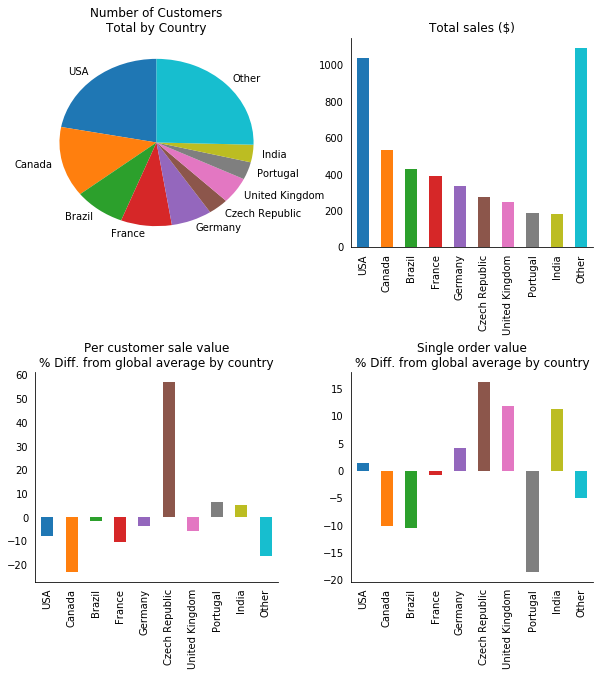

In [45]:
# Visualize all data!
import numpy as np

fig, axes = plt.subplots(2,2,figsize=(10,10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.6, wspace=.3)
colors = [plt.cm.tab10(i) for i in np.linspace(0,1,sales_info_by_country.shape[0])]

# Total customers - this will be displayed as a pie chart
total_customers = sales_info_by_country["total_customers"].copy().rename("") # This to prevent the name from being displayed
total_customers.plot.pie(
    ax=ax1,
    startangle=90,
    title="Number of Customers\nTotal by Country",
    colormap=plt.cm.tab10,
    wedgeprops={"linewidth":.5} # Make the lines between wedges less visible
    )

# Total sales - displayed as a simple bar plot
total_sales = sales_info_by_country["total_sales"].copy()
total_sales.index.name = ""
total_sales.plot.bar(
    ax=ax2,
    title = "Total sales ($)",
    legend = False,
    color=colors
    )
ax2.tick_params(top=False, right=False, left=False, bottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Average sale value per customer - another bar plot, but scaled as the percent difference from the average of the averages!
average_sale = sales_info_by_country["average_sales_per_customer"].copy()
avg = average_sale.mean()
average_sale_diff = (average_sale/avg)*100 - 100
average_sale_diff.index.name = ""
average_sale_diff.plot.bar(
    ax=ax3,
    title = "Per customer sale value\n% Diff. from global average by country",
    legend = False,
    color=colors
    )
ax3.tick_params(top=False, right=False, left=False, bottom=False)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

# Average single order value - another bar plot, scaled as before
order_value = sales_info_by_country["average_single_order_value"].copy()
avg = order_value.mean()
order_value_diff = (order_value/avg)*100 - 100
order_value_diff.index.name = ""
order_value_diff.plot.bar(
    ax=ax4,
    title = "Single order value\n% Diff. from global average by country",
    legend = False,
    color=colors
    )
ax4.tick_params(top=False, right=False, left=False, bottom=False)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

### RESULTS
- The "Other" group (countries with a single customer) makes up a majority of the total sales. However total sale value and single order value underperform consistently for this group. The large number of countries involved further make marketing attempts in this group likely to be inefficient.
- India and most of all Czech Republic are the most promising country for expansion, on both total sale value and single order value accounts.
- Portugal has above average total sale value, but below average single order value. This may indicate that Portuguese customers buy small, but buy often. Marketing campaigns targeted towards regularly reminding customers of new single tracks may prove particularly beneficial.
- The United Kingdom has above average single order value, but below average total order value. Marketing campaigns geared towards promotion of larger packages (e.g. entire albums) may prove particularly beneficial.

##### Note that the sample population is fairly small, and that these conclusions are likely to be uncertain because of it. Small marketing campaigns designed to probe the markets in all of these countries may be useful to gain more insight.

## CHINOOK MARKET SEARCH: FULL ALBUMS
The final task in this scenario is to help the company decide whether a change in their business model is a good call or not. 

The company has learned from preliminary data that most of the music sales come from single tracks rather than from full albums. Since paying for the selling rights of music makes up a large amount of the company's expenses, the board wants to know whether to stop selling full albums outright or not. There would be some profit loss, but if it is small enough that loss will be outweighed by the savings guaranteed by the new business model.

In [46]:
# Data selection - this last one is tricky, because we must determine whether each invoice was a full album sale or not.
# To do this we must check whether an invoice contained all tracks from an album using an EXCEPT between the track IDs in
# the invoice and those in the album, using the ID of the first track in the invoice as reference. Furthermore we must do this
# twice with the EXCEPT terms switched around -- This is because EXCEPT returns all elements of the first group that are not 
# shared by the second group: if the first group is a subgroup of the second the EXCEPT will return NULL even though the second
# group has an extra element and is thus not identical with the first. Using an AND here will guarantee the EXCEPT result is
# truly NULL and that the invoice contained all tracks from the album.
q6 = '''
WITH 
    first_track AS (
        SELECT
            il.invoice_id, 
            MIN(il.track_id) first_track_id,
            (SELECT i.total FROM invoice i WHERE i.invoice_id == il.invoice_id) purchase_cost
        FROM invoice_line il
        GROUP BY il.invoice_id
    )
    
SELECT
    full_album,
    COUNT(invoice_id) number_of_invoices,
    ROUND(CAST(COUNT(invoice_id) AS FLOAT)/(SELECT COUNT(*) FROM invoice)*100,1) percent_total,
    SUM(purchase_cost) revenue,
    ROUND(CAST(SUM(purchase_cost) AS FLOAT)/(SELECT SUM(total) FROM invoice)*100,1) percent_total_revenue
FROM
    (SELECT 
        ft.*,
        CASE
            WHEN
                (SELECT il2.track_id FROM invoice_line il2
                 WHERE il2.invoice_id == ft.invoice_id
                EXCEPT
                SELECT t.track_id FROM track t
                 WHERE t.album_id == (
                     SELECT t2.album_id FROM track t2 WHERE t2.track_id == ft.first_track_id)) IS NULL
            AND
                (SELECT t.track_id FROM track t
                 WHERE t.album_id == (
                     SELECT t2.album_id FROM track t2 WHERE t2.track_id == ft.first_track_id)
                EXCEPT
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id == ft.invoice_id) IS NULL
            THEN "True"
            ELSE "False"
            END AS full_album
     FROM first_track ft)
GROUP BY full_album;'''

run_query(q6)

,full_album,number_of_invoices,percent_total,revenue,percent_total_revenue
0,False,500,81.4,3248.19,69.0
1,True,114,18.6,1461.24,31.0


### RESULTS
- Full albums are bought in 18.6% of cases, while single tracks are bought in the remaining 81.6% of cases.
- The revenue from full albums (\$1461.24) makes up 31% of the total revenues, while the revenue from single tracks (\$3248.19) makes up the remaining 69% of the total revenues.

Full album purchases, while consisting of a minority of cases, still make up almost a fifth of total purchases, and little less than a third of total revenues. The final decision on whether to continue to buy full albums from record companies should be taken by comparing the money saved by this purchasing strategy change (we cannot determine this with the data at our disposal) vs. the prospective profit loss from relinquishing full albums. 

##### It must be noted that at least some fraction of the profit loss may come back as single track purchases, but that a loss of customers due to the removal of a useful purchase option should also be expected. This is likely to have long-term negative effects.